In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [31]:
# 1 데이터 불러오기 (와인 품질 데이터셋)
from sklearn.datasets import load_wine

wine = load_wine()
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target
print("--- 저장할 데이터 (DataFrame) ---")
print(df.head())
print("---------------------------------")
df.to_csv('wine_data.csv', index=False, encoding='utf-8-sig')

print("\n'wine_data.csv' 파일이 성공적으로 저장되었습니다.")


--- 저장할 데이터 (DataFrame) ---
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  p

In [32]:
# 1 데이터 불러오기 (와인 품질 데이터셋)
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data  # 특성 데이터 (13개)
y = wine.target.reshape(-1, 1)  # 라벨 데이터 (0, 1, 2)

# 🔹 품질 등급을 1~9 범위로 조정
y = y * 3 + 1  # 기존 0~2 등급을 1~9 등급으로 변환

# 2 데이터 전처리 (정규화 및 훈련/테스트 분할)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# random_state=42, 동일성 보장, 같은 데이터를 뽑는 용도
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3 PyTorch 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [33]:
# 4 MLP 모델 정의
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50)  # 입력층 → 은닉층1
        self.fc2 = nn.Linear(50, 30)  # 은닉층1 → 은닉층2
        self.fc3 = nn.Linear(30, 1)  # 은닉층2 → 출력층
        self.dropout = nn.Dropout(0.5)  # 50% 드롭아웃
        self.relu = nn.ReLU()  # 활성화 함수

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # 드롭아웃 적용
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # 출력층 (회귀이므로 활성화 함수 없음)
        return x

Epoch [100/1000], Loss: 0.3963
Epoch [200/1000], Loss: 0.2033
Epoch [300/1000], Loss: 0.1180
Epoch [400/1000], Loss: 0.0887
Epoch [500/1000], Loss: 0.0724
Epoch [600/1000], Loss: 0.0444
Epoch [700/1000], Loss: 0.0564
Epoch [800/1000], Loss: 0.0082
Epoch [900/1000], Loss: 0.0065
Epoch [1000/1000], Loss: 0.0027


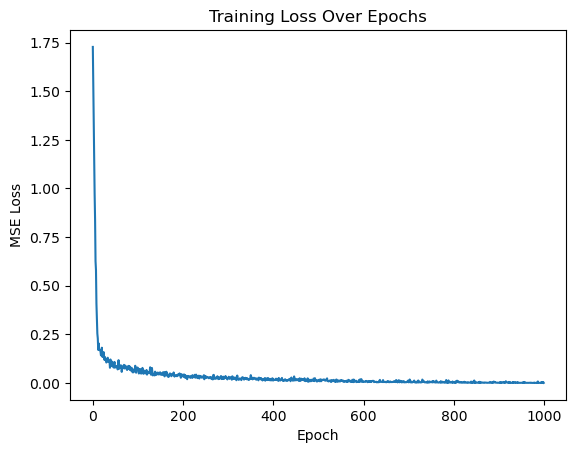

In [34]:
# 5 모델, 손실 함수, 최적화 함수 설정
model = Regressor()
criterion = nn.MSELoss()  # 손실 함수 (MSE)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam 최적화

# 6 학습 설정
num_epochs = 1000
batch_size = 32
train_losses = []

# 7 배치 학습을 위한 데이터로더 생성
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 8 모델 학습
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # 평균 손실 저장
    train_losses.append(epoch_loss / len(train_loader))

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 9 손실값 그래프 출력
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.show()

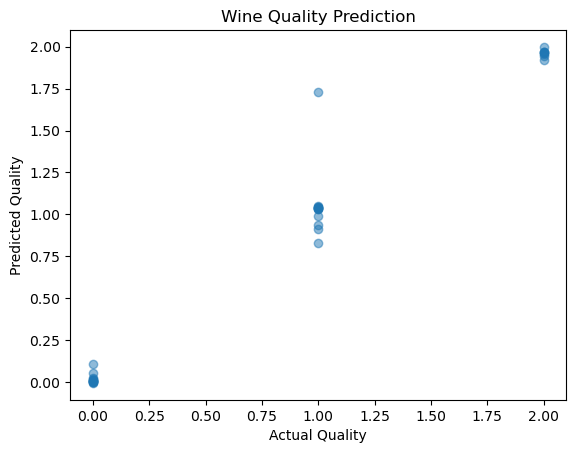

Test MSE: 0.0172


In [35]:
# 🔟 모델 평가 및 예측
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# 🔟 예측값 vs 실제값 시각화
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Wine Quality Prediction")
plt.show()

# 🔟 성능 평가 (MSE)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

In [36]:
# ⭐ 샘플 데이터 입력 및 예측 (1~9 정수 변환 추가) ⭐
def predict_sample(sample):
    """
    입력된 샘플 데이터를 모델을 통해 와인 품질을 예측하는 함수.
    예측된 품질을 1~9 범위의 정수로 변환하여 출력함.
    """
    # 샘플 데이터 정규화
    sample = np.array(sample).reshape(1, -1)
    sample_scaled = scaler.transform(sample)
    sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

    # 모델 예측
    model.eval()
    with torch.no_grad():
        predicted_quality = model(sample_tensor).item()  # 예측값 변환

    # 🔹 1~9 범위 내로 조정 (반올림 후 범위 제한)
    predicted_quality_int = min(9, max(1, round(predicted_quality)))

    return predicted_quality, predicted_quality_int


# 📌 예제 샘플 데이터 (와인 특성 13개)
sample_data = [13.0, 2.0, 2.5, 15.0, 100.0, 2.5, 2.9, 0.28, 2.2, 5.5, 1.04, 3.0, 800.0]

# 🏆 예측 실행
predicted_quality, predicted_quality_int = predict_sample(sample_data)
print(f"🔍 샘플 데이터의 예측된 와인 품질 (실수값): {predicted_quality:.2f}")
print(f"✅ 샘플 데이터의 예측된 와인 품질 (정수 등급 1~9): {predicted_quality_int}")


🔍 샘플 데이터의 예측된 와인 품질 (실수값): -0.01
✅ 샘플 데이터의 예측된 와인 품질 (정수 등급 1~9): 1


In [37]:

# ⭐ 샘플 데이터 5개를 출력하고 기존 품질 vs 예측된 품질 비교 ⭐
def predict_multiple_samples(X_data, y_true, num_samples=5):
    """
    데이터셋에서 num_samples개의 샘플을 선택하여 모델 예측값과 실제 품질을 비교 출력
    """
    model.eval()
    indices = np.random.choice(len(X_data), num_samples, replace=False)  # 무작위 5개 샘플 선택
    samples = X_data[indices]  # 샘플 데이터 선택
    true_quality = y_true[indices].reshape(-1)  # 실제 품질

    # 샘플 데이터 정규화
    samples_scaled = scaler.transform(samples)
    samples_tensor = torch.tensor(samples_scaled, dtype=torch.float32)

    # 모델 예측 수행
    with torch.no_grad():
        predicted_quality = model(samples_tensor).numpy().flatten()

    # 🔹 1~9 범위 내로 변환 (반올림 후 범위 제한)
    predicted_quality_int = [min(9, max(1, round(q))) for q in predicted_quality]

    # 결과 출력
    print("\n🔍 샘플 5개 데이터 예측 결과:")
    print("=" * 60)
    print(f"{'샘플 인덱스':<12}{'실제 품질':<12}{'예측 품질 (실수)':<20}{'예측 품질 (정수)'}")
    print("=" * 60)
    for i, idx in enumerate(indices):
        print(f"{idx:<12}{true_quality[i]:<12.0f}{predicted_quality[i]:<20.2f}{predicted_quality_int[i]}")


# 🏆 샘플 5개 예측 실행
predict_multiple_samples(X, y)


🔍 샘플 5개 데이터 예측 결과:
샘플 인덱스      실제 품질       예측 품질 (실수)          예측 품질 (정수)
173         2           1.97                2
31          0           0.01                1
133         2           1.98                2
68          1           1.01                1
58          0           0.01                1
